In [2]:
import numpy as np
from numpy.linalg import inv
from sklearn.preprocessing import normalize
from scipy.optimize import linprog
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def heatmap(a):
    """a: 2D array to plot as a heatmap"""
    #plt.imshow(a, cmap='hot', interpolation='nearest')
    plt.imshow(a, cmap='gray', interpolation='nearest')
    plt.show()

In [5]:
#  +-----------> x
#  | . . . . .
#  | . . . . .
#  | . . . . .
#  | . . . . .
#  | . . . . .
#  v
# y
gamma = 0.9

In [6]:
# States
w, h = 5, 5
grid = np.zeros((w, h))
n = grid.size
S = np.eye(n, n)

In [7]:
# Actions
k = 5
A = np.eye(k)
UP, DOWN, RIGHT, LEFT, NOOP = 0, 1, 2, 3, 4

In [9]:
# Transition probabilities
P = np.zeros((k, n, n))
#
# P[a, s2, s1] is the probability of ending in state s2 given that the agent
# starts in state s1 and chose action a.
# It is important to note that the initial state is the column index, not the
# row index, so that we can use vector representation of state, S2 = P[a] . S1
#
# /!\ This is the transposed of what the paper calls P_a
#
# P[UP, (x, y), (x, y + 1)] = 0.7
# P[UP, (x, y), (x, y - 1)] = 0.1
# P[UP, (x, y), (x + 1, y)] = 0.1
# P[UP, (x, y), (x - 1, y)] = 0.1
# P[UP, (x, y), (other)] = 0

# Masks used to block illegal moves on grid border
mask = np.zeros((k, n))
grid.fill(1)
grid[0,:] = 0
mask[UP] = grid.reshape(-1)
grid.fill(1)
grid[-1,:] = 0
mask[DOWN] = grid.reshape(-1)
grid.fill(1)
grid[:,-1] = 0
mask[RIGHT] = grid.reshape(-1)
grid.fill(1)
grid[:,0] = 0
mask[LEFT] = grid.reshape(-1)

# `move` is the non randomized action transition tensor, used in a second time
# to build P
move = np.zeros((k, n, n))
move[UP]    = np.roll(S, shift=-w, axis=0) * mask[UP]
move[DOWN]  = np.roll(S, shift=+w, axis=0) * mask[DOWN]
move[RIGHT] = np.roll(S, shift=+1, axis=0) * mask[RIGHT]
move[LEFT]  = np.roll(S, shift=-1, axis=0) * mask[LEFT]

directions = [UP, DOWN, RIGHT, LEFT]
for d in directions:
    # First build the random diffusion
    P[d] += sum([ move[x] for x in directions if x != d ])
    # Normalize random diffusion and multiply it by 30%
    P[d] = normalize(P[d], axis=0, norm='l1') * 0.3
    # Add the main direction
    P[d] += move[d] * 0.7
    # Renormalize for cells in which random diffusion was 0
    P[d] = normalize(P[d], axis=0, norm='l1')

P[NOOP] = np.eye(n)


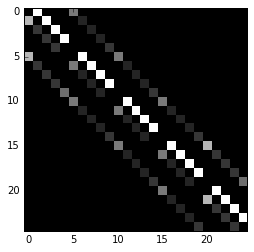

In [10]:
# Example of test of P:
# > P[LEFT].dot(S[17]).reshape(w, h)
# This will show a 2D matrix representing the grid with the probability of
# being in the cells given that we were in state 17 and chosed action LEFT.
heatmap(P[LEFT])

In [11]:
# "True" Reinforcement/Reward function, that we will try to guess.
grid.fill(0)
grid[0,-1] = 1
R = grid.reshape(-1)
Rmax = 1.0

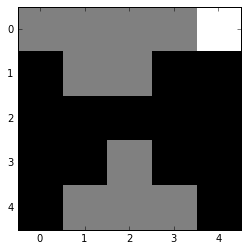

In [12]:
# Observed agent action decision policy, from which we'll try to recover R
# (for the case w = h = 5)
policy = np.array([
    [RIGHT, RIGHT, RIGHT, RIGHT, NOOP],
    [UP,    RIGHT, RIGHT, UP,    UP  ],
    [UP   , UP   , UP   , UP   , UP  ],
    [UP   , UP   , RIGHT, UP   , UP  ],
    [UP   , RIGHT, RIGHT, RIGHT, UP  ],
]).reshape(-1)

heatmap(policy.reshape(w, h))

In [13]:
# TODO: Linear pb to solve:
# max sum(i = 1..n, min(a = 1..k and a != policy[i], (P[policy[i]][i] - P[a][i]) . (I - gamma * P[policy[i]]).inverse() . R ) - lambd * norm1(R) )
# w/ (P[policy[i]][i] - P[a][i]) . (I - gamma * P[policy[i]]).inverse() . R >= 0 forall a != policy[i] 

I = np.eye(n)
nR = np.ndarray(n)
J = np.ndarray((k, n, n))
for a in range(k):
    J[a] = inv(I - gamma * P[a])

# Upper bound condition:
# (P[a1] - P[a]) . inv(I - gamma * P[a1]) . -R <= 0 forall a != a1 forall a1 = pi(s)
tr = np.transpose
nb_constraints = n * k * (k - 1) + n * (k - 1)
A = np.zeros((nb_constraints, 2 * n))
cursor = 0
# /!\ we assume here that all possible actions are used by the policy,
# i.e. {a | exists state s st. a = pi(s) } = A
# otherwise, we would have to take a1 in values(policy)
for ai in range(k):
    for aj in range(k):
        if ai == aj:
            continue
        A[cursor:cursor + n, 0:n] = tr(P[ai] - P[aj]).dot(tr(J[ai]))
        cursor += n

for i in range(n):
    a1 = policy[i]
    for a in range(k):
        if a == a1:
            continue
        A[cursor, 0:n] = tr(P[a1, :, i] - P[a, :, i]).dot(tr(J[a1]))
        A[cursor, n + i] = -1
        cursor += 1

b = np.zeros(nb_constraints)

lamb = 10000.
c = np.ndarray(2 * n)
c[:n] = -lamb
c[n:] = 1



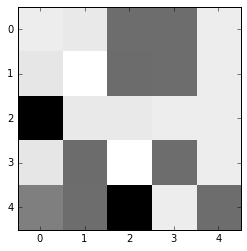

In [14]:
bounds = np.array( [(-Rmax, 0) for i in range(n)] + [(-1000000, 1000000) for i in range(n)] )

res = linprog(c, A, b, bounds=bounds)
heatmap(-res['x'][:n].reshape(w, h))
